# Testing analytical matrix generaiton

We're testing the script *matrix_building_analytical.py* here.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
import astropy.units as u

os.chdir('../../pastis/')
from config import CONFIG_PASTIS
import util as util
import image_pastis as impastis

In [ ]:
# Parameters

#############################################################
#nb_seg = CONFIG_PASTIS.getint('telescope', 'nb_subapertures')
nb_seg = 3       # just for now, to make testing faster
#############################################################

datadir = os.path.join(CONFIG_PASTIS.get('local', 'local_data_path'), 'active')
resDir = os.path.join(datadir, 'matrix_analytical')
nm_aber = CONFIG_PASTIS.getfloat('calibration', 'single_aberration') * u.nm
zern_number = CONFIG_PASTIS.getint('calibration', 'zernike')       # Noll convention!
zern_mode = util.ZernikeMode(zern_number)                       # Create Zernike mode object for easier handling

### Create the analytical matrix in notebook

In [ ]:
# Load baseline contrast
blcontr = np.loadtxt(os.path.join(datadir, 'calibration', 'base-contrast_piston_Noll1.txt'))

#-# Generating the PASTIS matrix
matrix_direct = np.zeros([nb_seg, nb_seg])   # Generate empty matrix
all_ims = []
all_dhs = []
all_contrasts = []

for i in range(nb_seg):
    for j in range(nb_seg):

        print('STEP:', str(i+1) + '-' + str(j+1), '/', str(nb_seg) + '-' + str(nb_seg))

        # Putting aberration only on segments i and j
        tempA = np.zeros([18])    # This would usually be tempA = np.zeros([nb_seg]), but we're varying nb_seg here
        tempA[i] = nm_aber.value        # to be able to do quick tests, but we still need the 18-element array
        tempA[j] = nm_aber.value        # so that impastis.analytical_model() works properly
        tempA *= u.nm    # making sure this array has the right units

        # Create PASTIS image and save full image as well as DH image
        temp_im_am, full_psf = impastis.analytical_model(zern_number, tempA, cali=True)

        filename_psf = 'psf_' + zern_mode.name + '_' + zern_mode.convention + str(zern_mode.index) + '_segs_' + str(i+1) + '-' + str(j+1)
        util.write_fits(full_psf, os.path.join(resDir, 'psfs', filename_psf + '.fits'), header=None, metadata=None)
        all_ims.append(full_psf)

        filename_dh = 'dh_' + zern_mode.name + '_' + zern_mode.convention + str(zern_mode.index) + '_segs_' + str(i+1) + '-' + str(j+1)
        util.write_fits(temp_im_am, os.path.join(resDir, 'darkholes', filename_dh + '.fits'), header=None, metadata=None)
        all_dhs.append(temp_im_am)

        contrast = np.mean(temp_im_am[np.where(temp_im_am != 0)])
        matrix_direct[i,j] = contrast
        print('contrast =', contrast)
        all_contrasts.append(contrast)

all_ims = np.array(all_ims)
all_dhs = np.array(all_dhs)
all_contrasts = np.array(all_contrasts)

In [ ]:
# Flick through analytical images and dark holes
imnum1 = 5

# Figure out what segment pair the number "imnum" corresponds to
seg1 = int(np.floor(imnum1/nb_seg)) + 1
seg2 = imnum1%nb_seg + 1

plt.figure(figsize=(18, 9))
plt.suptitle('Segment pair:' + str(seg1) + '-' + str(seg2))
plt.subplot(1, 2, 1)
plt.imshow(util.zoom_cen(all_ims[imnum1], 26), norm=LogNorm(), origin='lower')
plt.title('Whole PSF')
plt.subplot(1, 2, 2)
plt.imshow(all_dhs[imnum1], norm=LogNorm(), origin='lower')
plt.title('Dark hole')
plt.show()

print('Calculated contrast:', all_contrasts[imnum1])

In [ ]:
# Display the matrix where off-axis elements are not fixed yet
plt.imshow(matrix_direct, origin='lower')
plt.title('Analytical matrix')
plt.show()

There should be a certain scatter between the values of the celles of the matrix, but they should all be approximately on tohe same scale. Once we do the calculation for the off-axis elements, the matrix diagonal should be standing out.

In [ ]:
print(matrix_direct[0,1])

### Calculating the off-axis elements

The PASTIS matrix formula for a cotrast calculation is - the $l$ indicates the Zernike mode we are working with:

$$C = C_0 + A_l M_l A_l^{\dagger}$$

To get an expression for $M$, we can write:

$$C_{end} = C - C_0 = A_l M_l A_l^{\dagger}$$

In order to demonstrate the equation, we can apply it to the case of an aperture with only two segments. For this purpose we define $A_l = \begin{pmatrix} \alpha \\ \beta \end{pmatrix}$ and $M_l = \begin{pmatrix} a & b \\ c & d \end{pmatrix}$ which we can insert:

$$C_{end} = A_l M_l A_l^{\dagger} = \begin{pmatrix} \alpha \\ \beta \end{pmatrix} \begin{pmatrix} a & b \\ c & d \end{pmatrix} \begin{pmatrix} \alpha & \beta \end{pmatrix}$$

Doing the matrix multiplication yields - we'll come back to this (A):

$$ C_{end} = \alpha^2 a + \alpha \beta b + \alpha \beta c + \beta^2 d = a \alpha^2 + (b+c) \alpha \beta + d \beta^2 $$

Equation 17 in Leboulleux et al. (2018) is given as:

$$I(u) = ||\hat{Z_l}(u)||^2  \Bigg[ \sum_{k=1}^{n_{seg}} c^2_{k,l}\ a^2_{k,l} + \sum_{i=1}^{n_{seg}} \sum_{j=1, j\neq i}^{n_{seg}} c_{i,l}\ a_{i,l}\ c_{j,l}\ a_{j,l}\ cos[(\boldsymbol{r_j} - \boldsymbol{r_i}) \cdot \boldsymbol{u}] \Bigg] $$

We can put this expression in terms of contrast. Contrast is the averaged intensity over the dark hole (DH):

$$C = \langle I(u) \rangle_{DH}$$

With this, we express the equation for $I(u)$ in terms of contrast, like in Eq. 20. Plus, for simplicity, we will omit the Zernike index $l$:

$$C_{end} = \sum_{i=1}^{n_{seg}} \sum_{j=1}^{n_{seg}} c_{i}\ a_{i}\ c_{j}\ a_{j}\ \langle ||\hat{Z_l}(u)||^2  cos[(\boldsymbol{r_j} - \boldsymbol{r_i}) \cdot \boldsymbol{u}]\rangle_{DH}$$

But we keep the split between the sums of $i=j$ and $i \neq j$, like in Eq. 17 - (B):

$$C_{end} = \sum_{k=1}^{n_{seg}} \langle ||\hat{Z_l}(u)||^2 \rangle_{DH}\ c^2_{k}\ a^2_{k} + \sum_{i=1}^{n_{seg}} \sum_{j=1}^{n_{seg}} c_{i}\ a_{i}\ c_{j}\ a_{j}\ \langle ||\hat{Z_l}(u)||^2  cos[(\boldsymbol{r_j} - \boldsymbol{r_i}) \cdot \boldsymbol{u}]\rangle_{DH}$$

There is no cosine in the first sum because $cos[(\boldsymbol{r_j} - \boldsymbol{r_i}) \cdot \boldsymbol{u}] = cos[(\boldsymbol{r_k} - \boldsymbol{r_k}) \cdot \boldsymbol{u}] = cos[0] = 1$.

We can expand equation (2) for $nseg = 2$ and I will replace $\langle ||\hat{Z_l}(u)||^2 \rangle_{DH} = Z^2$ and $cos[(\boldsymbol{r_j} - \boldsymbol{r_i}) \cdot \boldsymbol{u}] = cos(...)$ for the sake of readability - (C):

$$C_{end} = Z^2\ c^2_{1}\ a^2_{1} + Z^2\ c^2_{2}\ a^2_{2} + Z^2\ c_1\ c_2\ a_1\ a_2\ cos(...) + Z^2\ c_2\ c_1\ a_2\ a_1\ cos(...) = \\ = Z^2\ c^2_1\ a^2_1 + Z^2\ c^2_2\ a^2_2 + 2\ Z^2\ c_1\ c_2\ a_1\ a_2\ cos(...)$$

Comparing equation (A) with equation (C), we can see:

$$ C_{end} = a \alpha^2 + d \beta^2 + (b+c) \alpha \beta = Z^2\ c^2_1\ a^2_1 + Z^2\ c^2_2\ a^2_2 + 2\ Z^2\ c_1\ c_2\ a_1\ a_2\ cos(...) $$

(Note that the indexed variables $a_i$ are the local Zernike coeffitients while the nonindexed variable $a$ is the first entry of the matrix $M$. Since we defined the aberration vector $A = \begin{pmatrix} \alpha \\ \beta \end{pmatrix} = \begin{pmatrix} a_1 \\ a_2 \end{pmatrix}$, we can start identifying the individual matrix elements $a, b, c, d$:

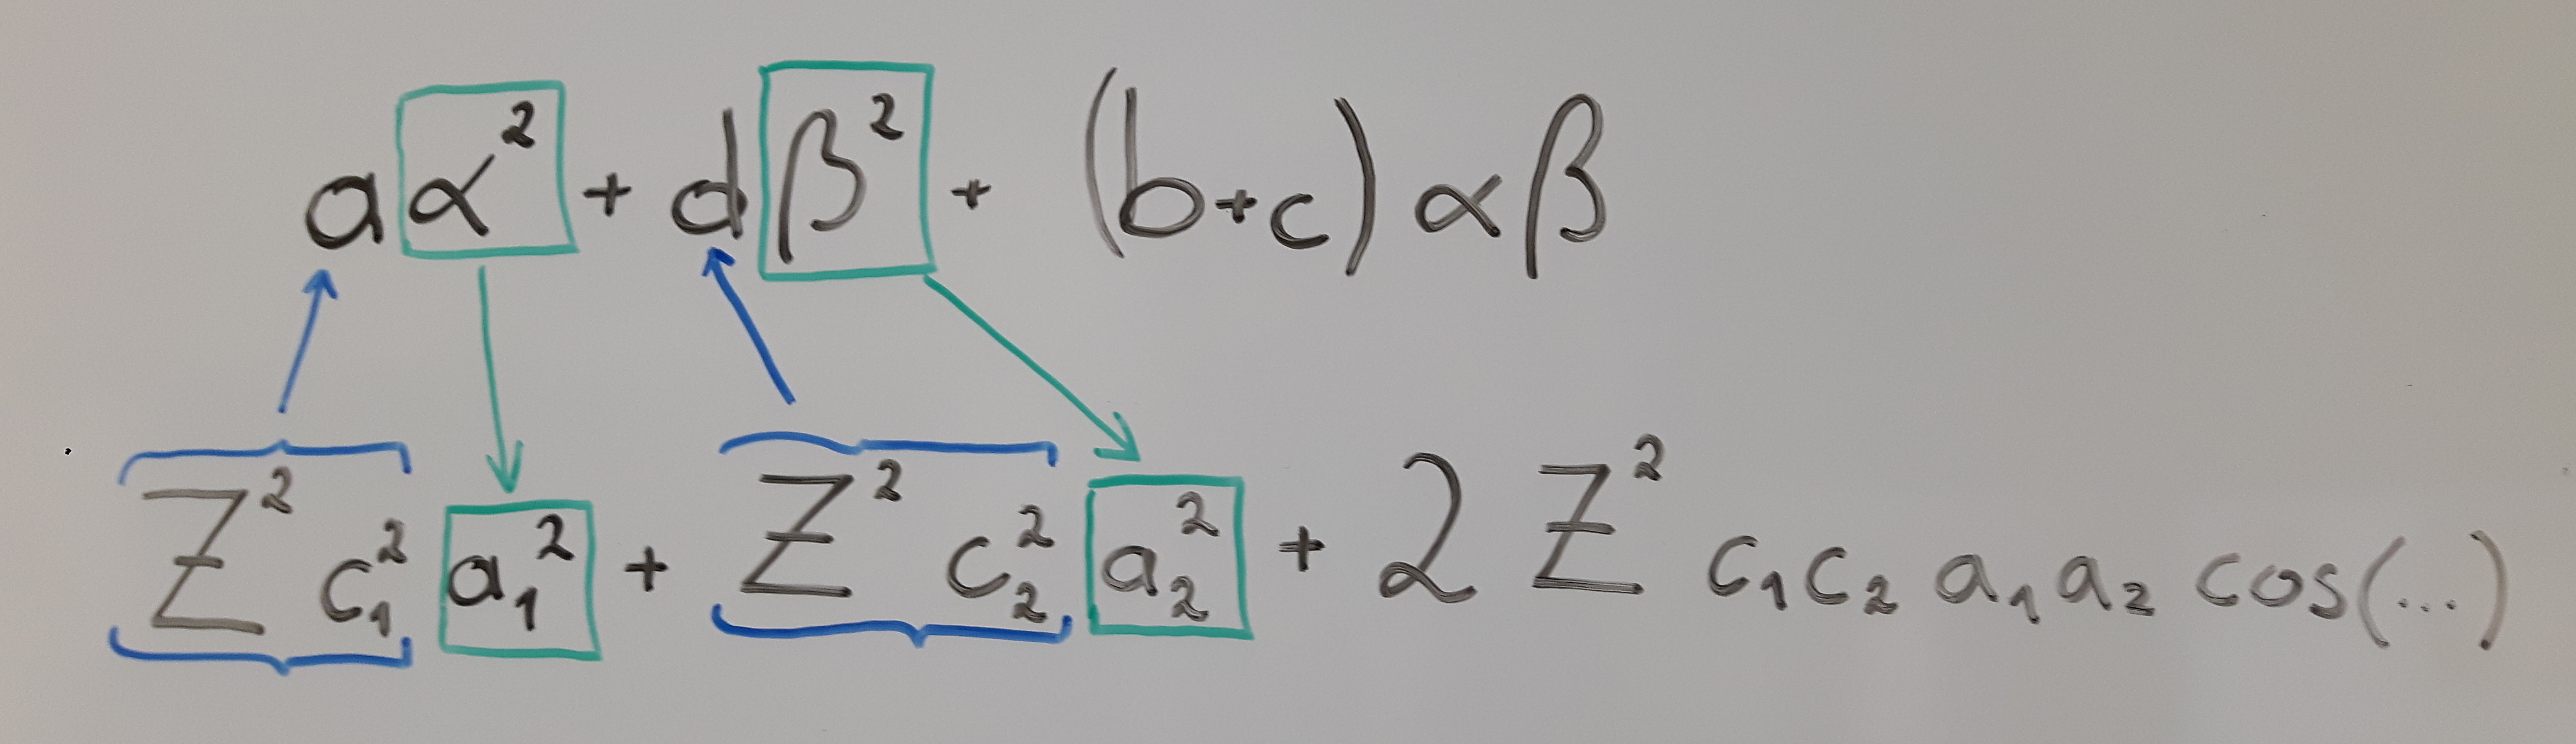

This means:

$$a = \langle ||\hat{Z_l}(u)||^2 \rangle_{DH}\ c^2_1$$
$$d = \langle ||\hat{Z_l}(u)||^2 \rangle_{DH}\ c^2_2$$

$a$ and $d$ are the diagonal matrix elements and they were created by only aberrating only a single segment. These matrix entries (a and d) are the contrast you get when you aberate only one segment and analytically, you calculate them from the calibrated (multiplication by $c^2_i$) dark hole intensity $||\hat{Z_l}(u)||^2$.

So far so good. Now on to get the off-axis elements $b$ and $c$ (see equation A):

$$C_{end} = a \alpha^2 + d \beta^2 + (b+c) \alpha \beta$$
$$b+c = [C_{end} - a \alpha^2 - d \beta^2] / (\alpha \beta)$$

$M$ is a symmetrical matrix, which means $b = c$ and hence:

$$b = c = [(C_{end} - a \alpha^2 - d \beta^2) / 2] / (\alpha \beta)$$

The $/ (\alpha \beta)$ is the normalization of the matrix. Lucie was always calculating everything with 1pm of aberration, so she didn't have to have the normalization in. Since I sometimes used 100nm or other values for the calibration, e.g. for JWST, I had to take the normalizatoin into account. And since we have $\alpha = \beta$ during the building of the matrix, we just have to divide the matrix by the single input aberration squared.

In [ ]:
# Filling the off-axis elements
matrix_two_N = np.copy(matrix_direct)
matrix_pastis = np.copy(matrix_direct)

for i in range(nb_seg):
    for j in range(nb_seg):
        if i != j:
            matrix_off_val = (matrix_two_N[i,j] - matrix_two_N[i,i] - matrix_two_N[j,j]) / 2.
            matrix_pastis[i,j] = matrix_off_val
            print('Off-axis for i' + str(i+1) + '-j' + str(j+1) + ': ' + str(matrix_off_val))

In [ ]:
# Display the final matrix
plt.imshow(matrix_pastis, origin='lower')
plt.title('Analytical matrix')
plt.show()

In [ ]:
print(matrix_pastis[2,0])

## Displaying the results from the integrated script on the repo

In [ ]:
# Read the matrix
filename_matrix = 'PASTISmatrix_' + zern_mode.name + '_' + zern_mode.convention + str(zern_mode.index)
matrix = fits.getdata(os.path.join(resDir, filename_matrix + '.fits'))

# Read the PSFs
psf_cube = fits.getdata(os.path.join(resDir, 'psfs', 'psf_cube' + '.fits'))

# Read the DH images
dh_cube = fits.getdata(os.path.join(resDir, 'darkholes', 'dh_cube' + '.fits'))

# Read the contrasts
con = np.loadtxt(os.path.join(resDir, 'pair-wise_contrasts.txt'))

In [ ]:
# Display analytical matrix
plt.figure(figsize=(10, 10))
plt.imshow(matrix, origin='lower')
plt.show()

In [ ]:
# You can flick through the images here
nb_seg = 18   # this has to be the same number like in the script you ran (and will usually be 18)
imnum2 = 200

# Figure out what segment pair the number "imnum" corresponds ro
seg1 = int(np.floor(imnum2/nb_seg)) + 1
seg2 = imnum2%nb_seg + 1

zoomim = 26

plt.figure(figsize=(18, 9))
plt.suptitle('Segment pair:' + str(seg1) + '-' + str(seg2))
plt.subplot(1, 2, 1)
plt.imshow(util.zoom_cen(psf_cube[imnum2], zoomim), norm=LogNorm(), origin='lower')
plt.title('Whole PSF')
plt.subplot(1, 2, 2)
plt.imshow(dh_cube[imnum2], norm=LogNorm(), origin='lower')
plt.title('Dark hole')
plt.show()